# HEROS: Demonstration Notebook
This notebook is set up as a demonstration for running the HEROS algorithm on different example datasets (with a binary outcome). This major sections of this notebook includes the following:
* Notebook Run Parameters
* Package Imports and Folder Management
* Example Data Setup
* Load and Prepare Training Dataset (including expert knowledge score generation - optionally used by HEROS)
* Run HEROS (Training)
* Testing Data Evaluation (focused on the top model from the model Pareto-front automatically chosen by the recommended strategy)
* Visualize Top Model (i.e. Rule-Set) For Interetation
* Calculating Top Model Feature Importance Estimates
* Example Prediction Reasoning Explanation (With Top Model)
* Visualize Rule and Model Population Pareto Fronts
* Saving Rule and Model Populations as Output
* Save and Visualize Learning Performance across Phase I and Phase 2 Training Iterations
* Saving Other Outputs
* Visual Interpretation and Predictions With the Whole Phase I Rule Population
* Testing Evaluation with Top Default Model or Custom Selected Model
* Evaluation of Stored Rule Populations (At User-Specified Iteration Checkpoints)
* Evaluation of Stored Top Model (At User-Specified Iteration Checkpoints)

## Example Dataset Options
### **MUX6: (6-bit Multiplexer Dataset)**
Prior to 90/10 partitioning (into train/test sets), included 500 instances (not all unique) and 6 total features (all predictive) with no noise (i.e. an trained model is capable of predicting with 100% accuracy). Features A_0 and A_1 are 'address-bits' that are predictive for every instance. Features R_0, R_1, R_2, and R_3 are 'register-bits' that are predictive for about 1/4 of all instances, each. All features and outcome (i.e. 'class') are binary-valued, and there are no missing values. MUX datasets involved feature interactions and heterogeneous patters of association. 
### **MUX11: (11-bit Multiplexer Dataset)**
Prior to 90/10 partitioning, included 5000 instances and 11 total features (all predictive) with no noise. Features A_0, A_1, and A_2 are 'address-bits', while the rest are register bits.
### **MUX20: (20-bit Multiplexer Dataset)**
Prior to 90/10 partitioning, included 10000 instances and 20 total features (all predictive) with no noise. Features A_0, A_1, A_2, and A_3 are 'address-bits', while the rest are register bits.
### **GAM_A: (GAMETES Simulated Dataset A - 4 Additive Univariate Features)**
Prior to 90/10 partitioning, included 1600 instances and 100 total features (4 are predictive - M0P0, M1P0, M2P0, M3P0) with a small degree of overall simulated noise. Each feature has a univariate association with outcome, with the strongest association being an additive combination of all 4 predictive features. Outcome (i.e. 'Class') is binary-valued.
### **GAM_C: (GAMETES Simulated Dataset C - 2-way Epistatic Interaction)**
Prior to 90/10 partitioning, included 1600 instances and 100 total features (2 are predictive - M0P0, M0P1) with about 60% simulated noise. Both predictive features have low/no univariate association with outcome. Outcome (i.e. 'Class') is binary-valued.
### **GAM_E: (GAMETES Simulated Dataset E - 4 Heterogeneous Univariate Features)**
Prior to 90/10 partitioning, included 1600 instances and 100 total features (2 are predictive - M0P0, M0P1) with about 60% simulated noise. Both predictive features have low/no univariate association with outcome. Outcome (i.e. 'Class') is binary-valued.

***
## Notebook Run Parameters
The parameters below control basic notebook functionality and allow users to change other HEROS run parameters for this demonstration.

In [1]:
# Notebook Operation Parameters ---------------------------------------------------------------------------------
load_from_cloned_repo = True # Leave True if running from cloned repository, and change to False if relying on 'pip' installation of HEROS
local_save = True # If True, saves output in pre-designated local folder within cloned repository folder
folder_path = './output' # Specify new path for output files generated by this notebook (if local_save = False)
run_all_cells = True # If True, run all cells of notebook (i.e. generate all example outputs and visualizations). False will only run key cells

# Specify which example dataset to run --------------------------------------------------------------------------
example_dataset = 'MUX6' # Dataset Options: 'MUX6', 'MUX11', 'MUX20', 'GAM_A', 'GAM_C', 'GAM_E'

# Expert Knowldge Generation Run Parameters ---------------------------------------------------------------------
max_instances = 2000 # Maximum number of available training instances to use in estimating feature importance scores with 'MultiSURF' algorithm.
use_turf = False # Idicate whether to use TuRF wrapper algorithm in combination with MultiSURF (recommended for large feature spaces, e.g. > 10000 features)
turf_pct = 0.2 # Controls the number of TuRF iterations as well as the number of features removed from calculations each iteration. (0.2 runs for 5 iterations with 20% of bottom scoring features removed each time)

# HEROS Key Hyperparameters -------------------------------------------------------------------------------------
iterations = 50000 # (Rule_I) Number of Phase I learning iterations (e.g. 50000)
pop_size = 500 # (Rule_P) Maximum size of Phase I rule population (micro-population size) (e.g. 500)
model_iterations = 100 # (Model_I) Number of Phase II learning iterations (e.g. 100)
model_pop_size = 100 # (Model_P) Maximum size of Phase II model population (e.g. 100)
nu = 1 # (v) Accuracy pressure (1 is neutral)

# Other HEROS Hyperparameters -----------------------------------------------------------------------------------
beta = 0.2 # (B) Average {M} size learning rate
theta_sel = 0.5 # (0_sel) {M} proportion for Phase I tournament selection
cross_prob = 0.8 # (p_cross) probability of applying crossover (Phase I and II)
mut_prob = 0.04 # (p_mut) probability of applying mutation (Phase I and II)
merge_prob = 0.1 # (p_merge) probability of applying merge (Phase II)
new_gen = 1.0 # Controls size of {OMP} as function of Model_P
model_pop_init = 'target_acc' # Model initialization method ('random' or 'target_acc')
subsumption = 'both' # Use GA, {C} or 'both' subsumption mechanisms ('ga', or 'c', 'both', or None)
rsl = 0 # Manually specify rule specificity limit (Give positive integer or leave 0 for automatic rule specificity limit determination from dataset properties)
compaction = 'sub' # rule compaction method ('sub' or None)
random_state = 42 # Applied random seed (for reproducibility)

# HEROS Performance tracking hyperparameters --------------------------------------------------------------------
track_performance = 1000 # Number of Phase I iterations where performance metrics are periodically estimated
model_tracking = True # Track top model performance across training iterations
stored_rule_iterations = '500,1000,5000,10000,50000' # Specified Phase I iterations where the current rule {P} is archived for external evaluation (e.g. '500,1000,5000,10000' or None)
stored_model_iterations = '10,50,100' # Specified Phase II iterations where the current {MP} is archived for external evaluation (e.g. '10,50,100', or None)
verbose = True # Run in 'verbose' mode - display run details

# In-Development HEROS Hyperparameters (Recommend not changing) -------------------------------------------------
outcome_type = 'class' # Only 'class' (i.e. classification outcome) is operational in current implementation
fitness_function = 'pareto' # Fitness function for Phase I rule discovery ('accuracy' or 'pareto') Pareto is strongly recommended unless analyzing clean problems.
feat_track = 'end' # Feature tracking strategy applied (None, 'add', 'wh', 'end') Experimental - recommended to leave to None
rule_pop_init = None # Specifies rule population pre-initialization method (None, 'load', or 'dt') Experimental - recommended to leave to None

***
## Package Imports & Folder Management:

In [2]:
# Load heros algorithm ---------------------------------------------------------
if load_from_cloned_repo: # Load HEROS algorithm locally from cloned github repository
    from src.skheros.heros import HEROS
else: # Load HEROS Notebook via pip installation
    from skheros.heros import HEROS

# Load all other packages used in this notebook --------------------------------
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skrebate import MultiSURF, TURF # Install using: pip install skrebate==0.7
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score

# Determine notebook output folder path ------------------------------------------------------
if not os.path.exists(folder_path):
        os.makedirs(folder_path)
if local_save:
    output_path = './output'
else:
    output_path = folder_path

# Report current working directory ---------------------------------------------
current_working_directory = os.getcwd()
print(current_working_directory)

c:\Users\ryanu\Documents\GitHub\heros


***
## Example Data Setup
Sets up the various options for each possible example dataset (as selected above by the user).

In [3]:
#Initialize dataset parameters
train_data_path = None
test_data_path = None
outcome_label = 'Class' # Class/outcome column label in target dataset
instanceID_label = 'InstanceID' #None for datasets without an instance ID column
excluded_column = None

if example_dataset == 'MUX6': # 6-bit Multiplexer
    train_data_path = 'evaluation/datasets/partitioned/multiplexer/A_multiplexer_6_bit_500_inst_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/multiplexer/A_multiplexer_6_bit_500_inst_CV_Test_1.txt'
    excluded_column = 'Group'
elif example_dataset == 'MUX11': # 11-bit Multiplexer
    train_data_path = 'evaluation/datasets/partitioned/multiplexer/B_multiplexer_11_bit_5000_inst_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/multiplexer/B_multiplexer_11_bit_5000_inst_CV_Test_1.txt'
    excluded_column = 'Group'
elif example_dataset == 'MUX20': # 20-bit Multiplexer
    train_data_path = 'evaluation/datasets/partitioned/multiplexer/C_multiplexer_20_bit_10000_inst_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/multiplexer/C_multiplexer_20_bit_10000_inst_CV_Test_1.txt'
    excluded_column = 'Group'
elif example_dataset == 'GAM_A': # GAMETES Dataset A (additive)
    train_data_path = 'evaluation/datasets/partitioned/gametes/A_uni_4add_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/gametes/A_uni_4add_CV_Test_1.txt'
elif example_dataset == 'GAM_C': # GAMETES Dataset C (epistasis)
    train_data_path = 'evaluation/datasets/partitioned/gametes/C_2way_epistasis_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/gametes/C_2way_epistasis_CV_Test_1.txt'
elif example_dataset == 'GAM_E': # GAMETES Dataset E (heterogeneous)
    train_data_path = 'evaluation/datasets/partitioned/gametes/E_uni_4het_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/gametes/E_uni_4het_CV_Test_1.txt'
    excluded_column = 'Model'
else:
    print("Specified Example Dataset Not Found!")

***
## Load and Prepare Training Dataset
Data used for training HEROS has the following requirements:
1. The training data must be passed as separate array-like objects including:
    1. 'X' {n_samples, n_features} Training instance features.
    3. 'y' {n_samples} Training labels of the outcome variable.
3. 'y must always be provided and must not include any missing values.
4. Missing values are allowed in 'X' but data instances should be excluded that have missing values for all features. Note, HEROS treats missing values as missing, i.e. no imputation of values are made or needed. Any rule that specifies a given feature will not match an instance with a missing value at that instance. 

Required data preparation here includes separating the loaded dataset into X and y array-like objects, and removing unnecessary columns. 

In [4]:
# Load training dataset ------------------------
train_df = pd.read_csv(train_data_path, sep="\t")
print(train_df.head())

# Create unique output folder for specific target dataset ------------------------
file_name = os.path.splitext(os.path.basename(train_data_path))[0]
output_path = output_path+'/'+file_name
if not os.path.exists(output_path):
        os.makedirs(output_path)

#Prepare Training Data ------------------------
try:
    X = train_df.drop(excluded_column, axis=1) #Remove excluded column from consideration in this notebook
except:
    X = train_df
    print('Excluded column not available')
try:
    X = X.drop(instanceID_label,axis=1)
except:
    print('Instance ID coulmn not available')

X = X.drop(outcome_label, axis=1)
feature_names = X.columns 
cat_feat_indexes = list(range(X.shape[1])) #all feature are treated as categorical so provide indexes 0-5 in this list for 6-bit multiplexer dataset e.g. [0,1,2,3,4,5]

#Finalize separate array-like objects for X and y
X = X.values
y = train_df[outcome_label].values #outcome values
try:
    row_id = train_df[instanceID_label].values #instance id values
except:
    row_id = None

   A_0  A_1  R_0  R_1  R_2  R_3  Class  Group  InstanceID
0    1    0    1    0    1    1      1      2           1
1    1    0    0    0    0    1      0      2           2
2    0    1    1    0    0    1      0      1           3
3    1    1    1    1    1    1      1      3           4
4    0    0    0    1    1    0      0      0           5


### Generate Expert Knowlege Scores for Features (Optional, but suggested in HEROS) 
Previous LCS research has indicated that using Relief-based algorithms such as 'MultiSURF' to generate feature importance scores as a guide for rule initialization improves evolutionary algorithm performance. Here we show how these scores can be generated, saved, and later used by HEROS for rule initialization. 

These scores only need to be generated once for a given training dataset and then can be saved for future use. This code only runs MultiSURF if the scores have not yet been generated for a training dataset with a unique name.

The MultiSURF (feature importance estimation) algorithm is found in our scikit-rebate respository at https://github.com/UrbsLab/scikit-rebate. 

In [5]:
def balanced_sampling(df,outcome_label, max_instances):
    """ Returns a dataframe with a sampled number of rows from the original (retaining class balance if possible).
        Assumes that outcome values are either 0 or 1. """
    # Split the DataFrame by class
    df_class_0 = df[df[outcome_label] == 0]
    df_class_1 = df[df[outcome_label] == 1]
    # Determine the number of rows to sample per class
    n_class_0 = max_instances // 2
    n_class_1 = max_instances - n_class_0  # Assign remaining rows to Class 1
    # Ensure we don't sample more rows than available
    n_class_0 = min(n_class_0, len(df_class_0))
    n_class_1 = min(n_class_1, len(df_class_1))
    # Sample rows from each class
    sampled_class_0 = df_class_0.sample(n=n_class_0, replace=False)
    sampled_class_1 = df_class_1.sample(n=n_class_1, replace=False)
    # Combine the sampled rows
    sampled_df = pd.concat([sampled_class_0, sampled_class_1]).reset_index(drop=True)
    return sampled_df

In [6]:
# Further data preparation for expert knowldge generation (i.e. balanced subsampling of training instances for faster run times)
fs_train_df = balanced_sampling(train_df, outcome_label, max_instances)
try:
    fs_X = fs_train_df.drop(excluded_column, axis=1) #Remove excluded column from consideration in this notebook
except:
    fs_X = fs_train_df
    print('Excluded column not available')
try:
    fs_X = fs_X.drop(instanceID_label,axis=1)
except:
    print('Instance ID coulmn not available')
fs_X = fs_X.drop(outcome_label, axis=1)
#Finalize separate array-like objects for X and y
fs_X = fs_X.values
fs_y = fs_train_df[outcome_label].values #outcome values
#Optional TURF Parameters --------------
num_scores_to_return = int(X.shape[1]/2.0)
# --------------------------------------
score_path_name = None
if use_turf:
    score_path_name = output_path+'/MultiSURF_TuRF_Scores.csv' #No need to change
else:
    score_path_name = output_path+'/MultiSURF_Scores.csv' #No need to change
# Calculate or load feature importance estimates with MultiSURF or MultiSURF+TuRF ------------------------------------
if not os.path.isfile(score_path_name):
    if use_turf: # Run MultiSURF with TuRF wrapper
        print("Generating MultiSURF/TuRF Scores:")
        clf = TURF(MultiSURF(n_jobs=None), pct=turf_pct, num_scores_to_return=num_scores_to_return).fit(fs_X, fs_y)
        ek = clf.feature_importances_
        score_data = pd.DataFrame({'Feature':feature_names,'Score':ek})
        score_data.to_csv(score_path_name,index=False)
    else: #Just run MultiSURF
        print("Generating MultiSURF Scores:")
        clf = MultiSURF(n_jobs=None).fit(fs_X, fs_y)
        ek = clf.feature_importances_
        score_data = pd.DataFrame({'Feature':feature_names,'Score':ek})
        score_data.to_csv(score_path_name,index=False)
else: #load previously trained scores
    print("Loading MultiSURF Scores")
    loaded_data = pd.read_csv(score_path_name)
    ek = loaded_data['Score'].tolist()
print(list(feature_names))
print(ek)

Loading MultiSURF Scores
['A_0', 'A_1', 'R_0', 'R_1', 'R_2', 'R_3']
[0.0653628803320886, 0.0917736536553188, 0.069767762335029, 0.0134458939320383, 0.0229747192062444, 0.0148895858857668]


***
## Run HEROS (Training)

1. (OPTIONAL) 'pop_df' is a DataFrame of a previously trained HEROS rule population that can be uploaded to initialize a new HEROS run.
2. (OPTIONAL) 'ek' is a numpy array or list of expert knowledge weights for all quantitative and categorical features in the dataset. They must be formatted as follows:
    1. This list must have the same number of elements as there are total features in the dataset (ordered in the same way)
    2. If a mix of quantiative and categorical features are loaded, HEROS will combine them with all quantitative features first, followed by all categorical features in the same order as provided in 'X' or 'Xc'.

In [7]:
# Initialize HEROS algorithm with run parameters
heros = HEROS(outcome_type=outcome_type,iterations=iterations,pop_size=pop_size,cross_prob=cross_prob,mut_prob=mut_prob,nu=nu,beta=beta,theta_sel=theta_sel,
              fitness_function=fitness_function,subsumption=subsumption,rsl=rsl,feat_track=feat_track, model_iterations=model_iterations,
              model_pop_size=model_pop_size,model_pop_init=model_pop_init,new_gen=new_gen,merge_prob=merge_prob,rule_pop_init=rule_pop_init,compaction=compaction,
              track_performance=track_performance,model_tracking=model_tracking,stored_rule_iterations=stored_rule_iterations,stored_model_iterations=stored_model_iterations,random_state=random_state, verbose=verbose)

heros = heros.fit(X, y, row_id, cat_feat_indexes=cat_feat_indexes, ek=ek)

Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 6
Total Features: 6
Total Instances: 450
Feature Types: [1, 1, 1, 1, 1, 1]
Missing Values: 0
Classes: [1, 0]
Class Counts: {1: 225, 0: 225}
Class Weights: {1: 0.5, 0: 0.5}
Majority Class: 1
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf]]
Categorical Feature Values: [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0]]
Average States: 2.0
Rule Specificity Limit: 6
Expert Knowledge Weights Used: True
--------------------------------------------------------------------
Archiving: 500
   Iteration  Pred.Acc.Est.  Unique Rule Count  Rule Pop Size  Total Time
0       1000          0.726                136            500       0.541
Archiving: 1000
   Iteration  Pred.Acc.Est.  Unique Rule Count  Rule Pop Size  Total Time
0       2000          0.812                152            500       1.122
   Iteration

***
## Testing Data Evaluation
### Load and Prepare Testing Data

In [8]:
# Load testing dataset ---------------------------
test_df = pd.read_csv(test_data_path, sep="\t")
print(test_df.head())
#Prepare Testing Data ----------------------------
try:
    X_test = test_df.drop(excluded_column, axis=1)
except:
    X_test = test_df
try:
    X_test = X_test.drop(instanceID_label, axis=1)
except:
    pass
X_test = X_test.drop(outcome_label, axis=1)
#Finalize separate array-like objects for X and y
X_test = X_test.values
y_test = test_df[outcome_label].values #outcome values

   A_0  A_1  R_0  R_1  R_2  R_3  Class  Group  InstanceID
0    0    0    0    1    0    0      0      0           8
1    1    0    0    1    1    0      1      2          14
2    0    0    1    1    1    1      1      0          29
3    1    1    0    0    1    0      0      3          44
4    0    0    1    1    0    0      1      0          58


### Identify Top Model from the Model Pareto Front
Evaluates the testing data performance of all non-dominated models on the top-ranking Phase II Pareto front, each treated as a candidate solution. Stepping through all non-dominated models, we replace the current best if the next model either (1) has > balanced testing accuracy and >= testing coverage, or (2) has >= balanced testing accuracy, >= testing coverage, and a smaller rule count.

In [9]:
best_model_index = heros.auto_select_top_model(X_test,y_test,verbose=True)
set_df = heros.get_model_rules(best_model_index)
print(set_df) #Print all rules of the top model

9 non-dominated models on Pareto-front.
----------------------------------------
Model testing accuracies: [1.0, 0.96, 0.96, 0.8999999999999999, 0.76, 0.72, 0.72, 0.6799999999999999, 0.64]
Model testing coverages: [1.0, 0.96, 0.94, 0.9, 0.92, 0.8, 0.82, 1.0, 0.46]
Model rule counts: [8, 7, 7, 6, 5, 5, 4, 2, 1]
----------------------------------------
Best model testing accuracy: 1.0
Best model testing coverage: 1.0
Best rule count: 8
Best model index: 0
----------------------------------------
  Condition Indexes Condition Values  Action  Numerosity   Fitness  \
0         [2, 1, 0]        [0, 0, 0]       0           6  1.000000   
1         [0, 3, 1]        [0, 0, 1]       0           9  0.997714   
2         [4, 1, 0]        [0, 0, 1]       0           4  0.997857   
3         [2, 1, 0]        [1, 0, 0]       1          10  0.998714   
4         [1, 5, 0]        [1, 0, 1]       0           9  0.996857   
5         [1, 0, 5]        [1, 1, 1]       1           7  0.997429   
6         [

### Evaluate Top Model Performance

In [10]:
# Report performance results for the top model
predictions = heros.predict(X_test,whole_rule_pop=False, target_model=best_model_index)
print("HEROS Top Model Testing Data Performance Report:")
print(classification_report(predictions, y_test, digits=8))

HEROS Top Model Testing Data Performance Report:
              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000        25
           1  1.00000000 1.00000000 1.00000000        25

    accuracy                      1.00000000        50
   macro avg  1.00000000 1.00000000 1.00000000        50
weighted avg  1.00000000 1.00000000 1.00000000        50



### Get Prediction Probabilities and Coverage Confirmation for all Testing Instances

In [11]:
predict_prob = heros.predict_proba(X_test,whole_rule_pop=False, target_model=best_model_index)
print("Prediction Probabilities for all Testing Instances:")
print(predict_prob)

predict_cover = heros.predict_covered(X_test,whole_rule_pop=False, target_model=best_model_index)
print("Coverage for all Testing Instances:")
print(predict_cover)
print(str(sum(predict_cover))+' instances covered out of '+str(len(predict_cover)))

Prediction Probabilities for all Testing Instances:
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Coverage for all Testing Instances:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
50 instances covered out of 50


### ROC Plot of Top Model Testing Performance
Set up for binary classification tasks.

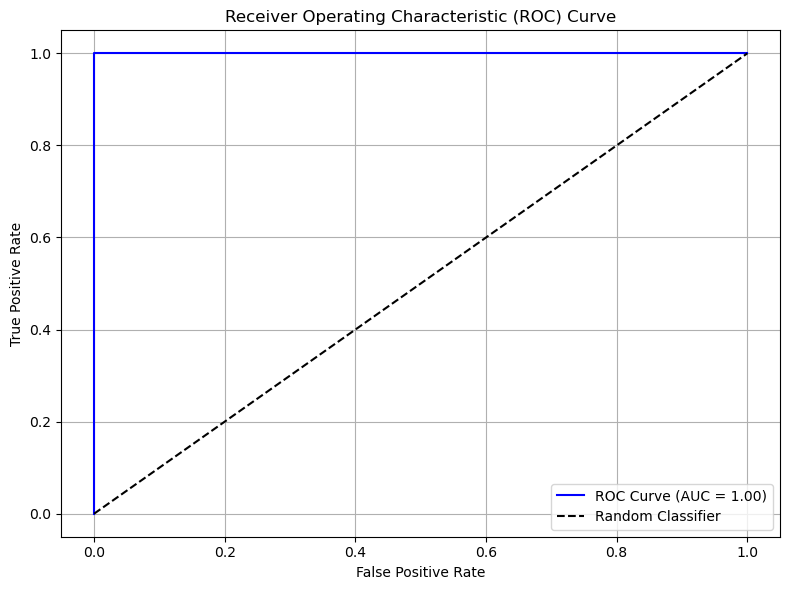

In [12]:
# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:, 1]) #based on class 1
# Calculate AUC
roc_auc = roc_auc_score(y_test, predict_prob[:, 1]) #based on class 1
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Save Rules of Top Model

In [13]:
set_df = heros.get_model_rules(best_model_index)
set_df.to_csv(output_path+'/top_testing_model_rules.csv', index=False)

***
## Visualize Top Model (i.e. Rule-Set) For Interetation
### Specified Features Heatmap

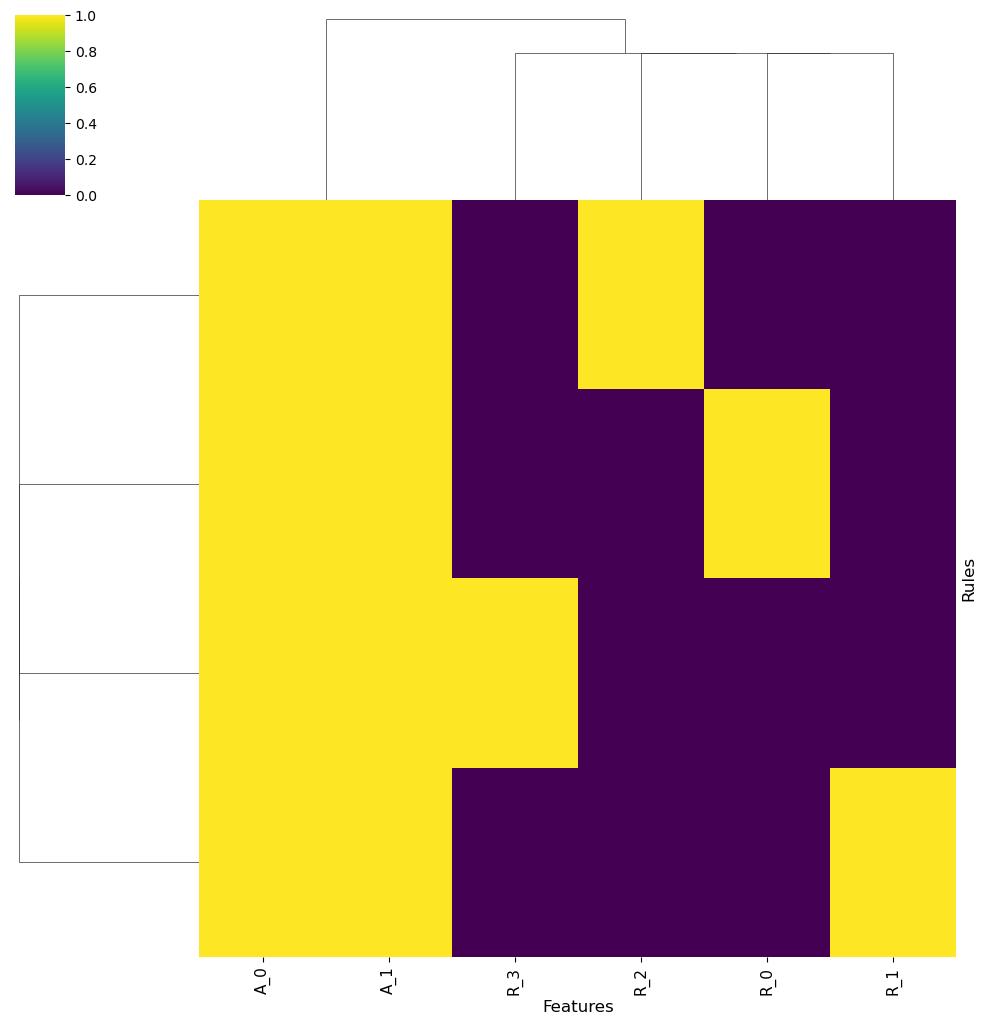

In [14]:
if run_all_cells:
    heros.get_rule_set_heatmap(feature_names, best_model_index, weighting='useful_accuracy', specified_filter=1, display_micro=False, show=True, save=True, output_path=output_path)

### Feature Specification as Network with Feature Co-Occurence as Edges

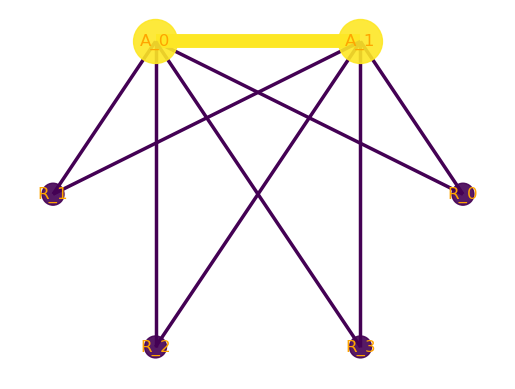

In [15]:
if run_all_cells:
    node_size = 1000
    edge_size = 10
    heros.get_rule_set_network(feature_names, best_model_index, weighting='useful_accuracy', display_micro=False, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=output_path)

### Feature Tracking Scores (Across Training Instances)

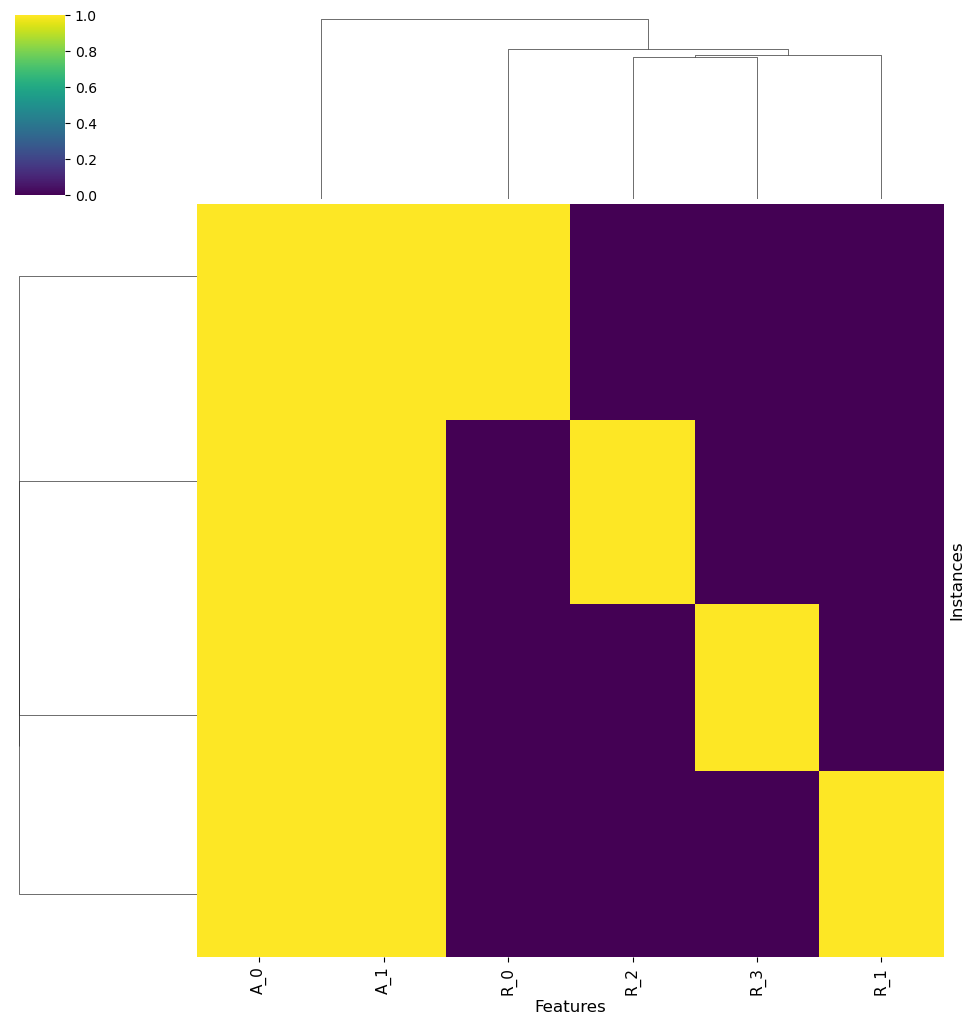

In [16]:
if run_all_cells and feat_track != None:
    heros.run_model_feature_tracking(best_model_index)
    # Save Feature Tracking Scores to .csv
    ft_df = heros.get_model_ft(feature_names)
    ft_df.shape
    ft_df.to_csv(output_path+'/rule_set_'+str(best_model_index)+'_feature_tracking_scores.csv', index=False)
    # Visualize feature tracking scores as clustered heatmap
    heros.get_clustered_model_ft_heatmap(feature_names, specified_filter=1, show=True, save=True, output_path=output_path)


***
## Calculating Top Model Feature Importance Estimates
Using scikit-learn's permutation importance package function.

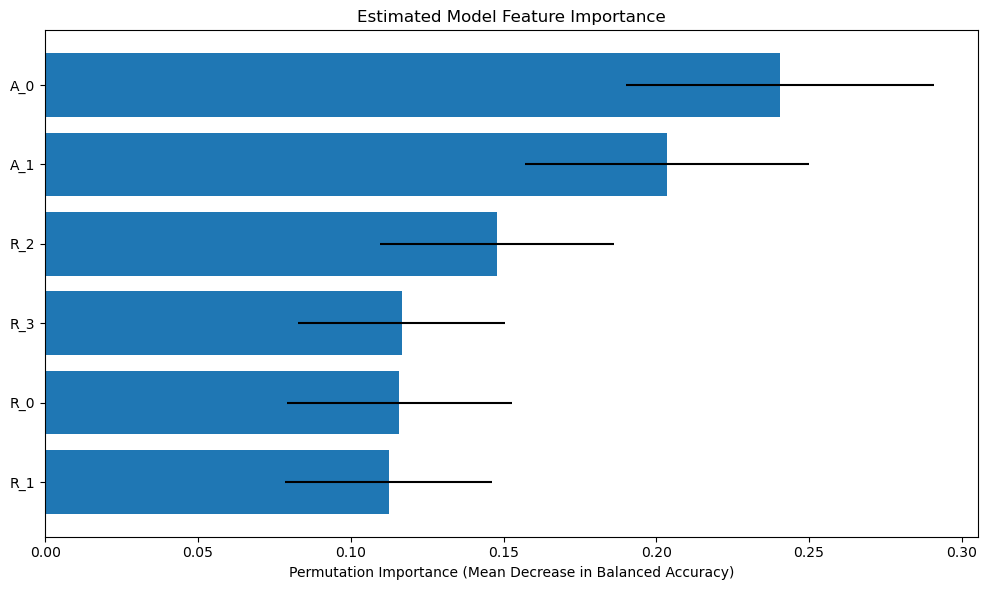

In [17]:
# Run permutation importance
result = permutation_importance(heros, X_test, y_test, n_repeats=100, random_state=random_state, scoring='balanced_accuracy')
# Extract importance means
importances = result.importances_mean
std = result.importances_std
# Sort features by importance
sorted_idx = importances.argsort()[::-1]
# Generate Simple Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], xerr=std[sorted_idx])
plt.xlabel("Permutation Importance (Mean Decrease in Balanced Accuracy)")
plt.title("Estimated Model Feature Importance")
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()

***
## Example Prediction Reasoning Explanation (With Top Model)
When applying the trained models to unlabeled data for prediction, the cells in this section give a basic example of how the prediction reasoning may be explained in clear human interpretable terms. 

In [18]:
# Get example testing instance (with no label) --------------------------------
print("Total Number of Available Testing Instances: "+str(len(X_test)))
target_testing_instance_index = 0 #arbitrarily chosen as an example
target_testing_instance = X_test[target_testing_instance_index]
print("Making Prediction on Testing Instance Index: "+str(target_testing_instance_index))
# Apply prediction to target instance -----------------------------------------
heros.predict_explanation(target_testing_instance, feature_names, whole_rule_pop=False, target_model=best_model_index)

Total Number of Available Testing Instances: 50
Making Prediction on Testing Instance Index: 0
PREDICTION REPORT ------------------------------------------------------------------
Outcome Prediction: 0
Model Prediction Probabilities: {0: 1.0, 1: 0.0}
Instance Covered by Model: Yes
Number of Matching Rules: 1
PREDICTION EXPLANATION -------------------------------------------------------------
Supporting Rules: --------------------
6 rule copies assert that IF: (A_0 = 0) AND (A_1 = 0) AND (R_0 = 0) THEN: predict outcome '0' with 100.0% confidence based on 68 matching training instances (15.11% of training instances).
Contradictory Rules: -----------------
No contradictory rules matched.


***
## Visualize Rule and Model Population Pareto Fronts
### **Rule Population**

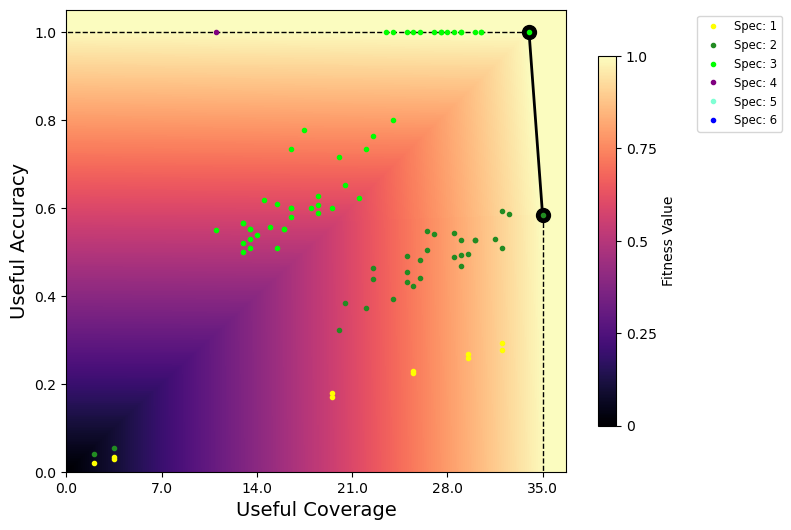

In [19]:
if run_all_cells:
    resolution = 500
    plot_rules = True
    color_rules = True
    heros.get_rule_pareto_landscape(resolution, heros.rule_population, plot_rules, color_rules,show=True,save=True,output_path=output_path)

### **Model Population**

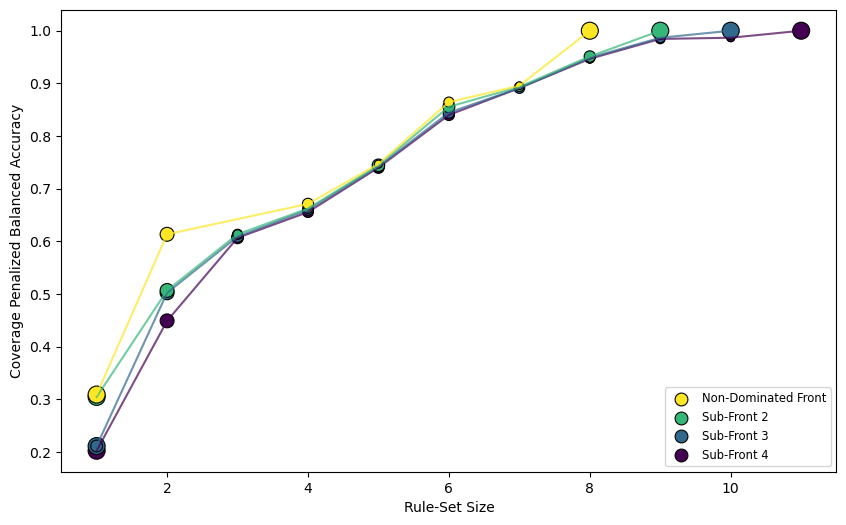

In [20]:
if run_all_cells:
    resolution = 500
    plot_models = True
    heros.get_model_pareto_fronts(show=True,save=True,output_path=output_path)

***
## Saving Rule and Model Populations as Output

In [21]:
# Save Rule Population as .csv
rule_pop_df = heros.get_pop()
rule_pop_df.to_csv(output_path+'/rule_pop.csv', index=False)
# Save Model Population as .csv
model_pop_df = heros.get_model_pop()
model_pop_df.to_csv(output_path+'/model_pop.csv', index=False)

***
## Save and Visualize Learning Performance across Phase I and Phase 2 Training Iterations
### **Phase I (Rule Learning)**

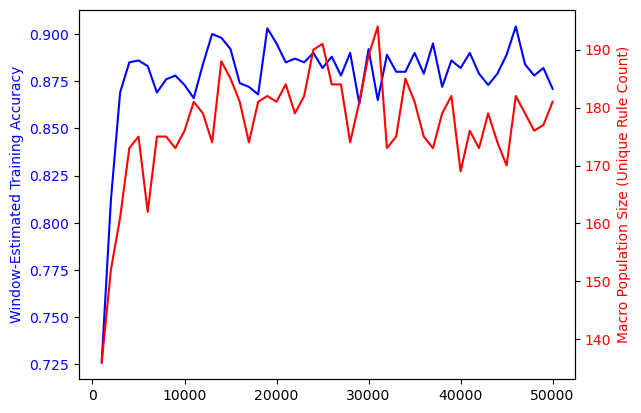

In [22]:
# Save Phase 1 Rule Training Performance Estimates to .csv
rule_tracking_df = heros.get_performance_tracking()
rule_tracking_df.to_csv(output_path+'/rule_pop_tracking.csv', index=False)
# Plot Rule Learning Tracking
heros.get_rule_tracking_plot(show=True,save=True,output_path=output_path)

### **Phase II (Model Learning)**

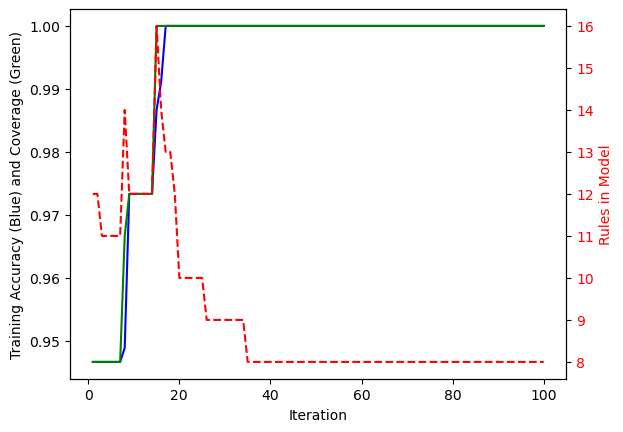

In [23]:
model_tracking_df = heros.get_model_performance_tracking()
model_tracking_df.to_csv(output_path+'/model_tracking.csv', index=False)
# Plot Model Learning Tracking
heros.get_model_tracking_plot(show=True,save=True,output_path=output_path)

***
## Saving Other Outputs
### Pickle Trained HEROS Object (For Future Use)

In [24]:
# Pickle HEROS object
with open(output_path+'/heros.pickle', 'wb') as f:
    pickle.dump(heros, f)
# Load previously pickled HEROS Object
with open(output_path+'/heros.pickle', 'rb') as f:
    heros = pickle.load(f)

### Document HEROS Run Paramter Settings

In [25]:
heros.save_run_params(output_path+'/heros_run_parameters.txt')

### Save Run Time Summary

In [26]:
time_df = heros.get_runtimes()
time_df.to_csv(output_path+'/runtimes.csv', index=False)
print(time_df)

      Global    Phase 1    Phase 2  Rule Initialization  Rule Covering  \
0  68.007836  30.122285  37.766018             0.003505       0.003501   

   Rule Equality  Rule Matching  Rule Evaluation  Feature Tracking  \
0       0.760143       2.683506        32.353842               0.0   

   Rule Subsumption  Rule Selection  Rule Mating  Rule Deletion  \
0          0.481301        1.046983     4.887369       2.322369   

   Rule Compaction  Rule Prediction  
0         0.003505         0.915155  


***
## Visual Interpretation and Predictions With the Whole Phase I Rule Population
### Vizualize Rule Population (Feature Specification) as a Rule-Clustered Heatmap (With Optional Rule-Weighting)
Parameters:
* *feature_names*: a list of feature names for the entire training dataset (given in original dataset order)
*  *weighting*: indicates what (if any) weighting is applied to individual rules for the plot ('useful_accuracy', 'fitness', None)
*  *specified_filter*: the number of times a given feature must be specified in rules of the population to be included in the plot (must be a positive integer or None)
*  *display_micro*: controls whether or not additional copies of rules (based on rule numerosity) should be included in the heatmap (True or False) 
*  *show*: indicates whether or not to show the plot (True or False)
*  *save*: indicates whether or not to save the plot to a specified path/filename (True or False)
*  *output_path*: a valid folder path within which to save the plot (str of folder path)
*  *data_name*: a unique name precursor to give to the plot (str)

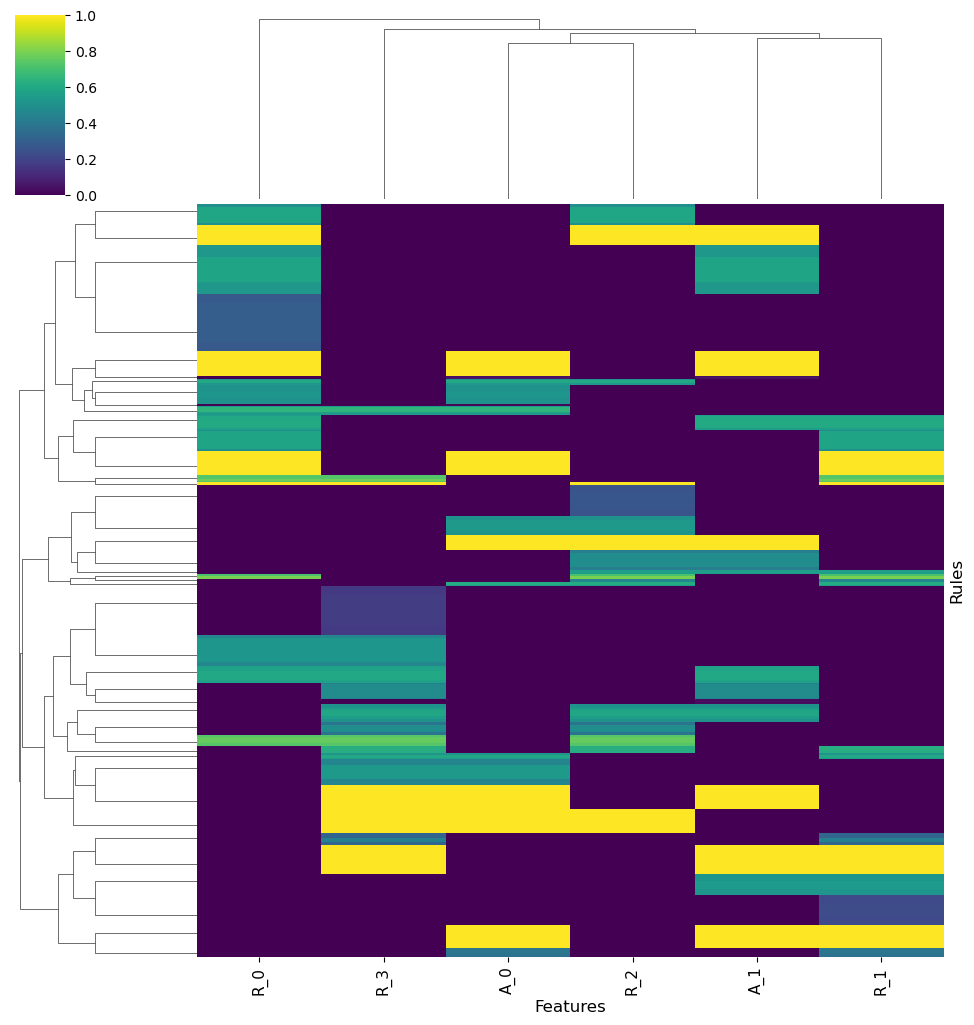

In [27]:
if run_all_cells:
    heros.get_rule_pop_heatmap(feature_names, weighting='useful_accuracy', specified_filter=1, display_micro=True, show=True, save=True, output_path=output_path)

### Vizualize Rule Population (Feature Specification) as a Network (With Optional Rule-Weighting)

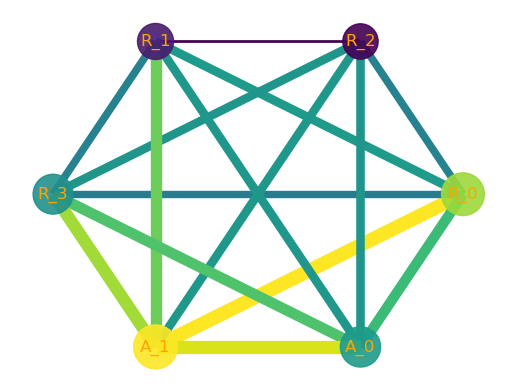

In [28]:
if run_all_cells:
    node_size = 1000
    edge_size = 10
    weighting = 'useful_accuracy'# 'useful_accuracy', 'fitness', None
    display_micro = True
    heros.get_rule_pop_network(feature_names, weighting=weighting, display_micro=display_micro, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=output_path)


### Vizualize Rule Population Feature Tracking Scores

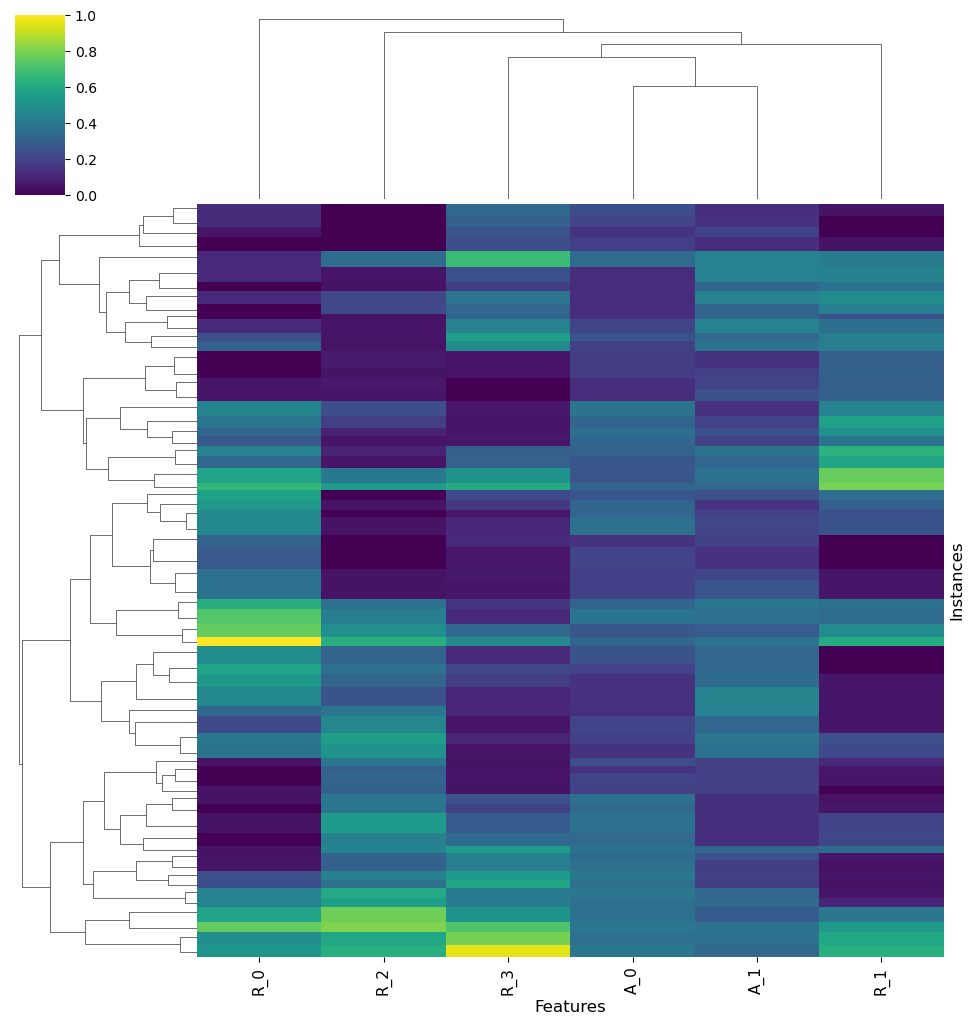

In [29]:
# Save Feature Tracking Scores to .csv
if heros.feat_track != None:
    ft_df = heros.get_ft(feature_names)
    ft_df.shape
    ft_df.to_csv(output_path+'/feature_tracking_scores.csv', index=False)
# Visualize clustered heatmap of feature tracking scores across all training instances
if heros.feat_track != None and run_all_cells:
    heros.get_clustered_ft_heatmap(feature_names, show=True, save=True, output_path=output_path)

### Prediction with Whole Phase I Rule Population

In [30]:
predictions = heros.predict(X_test,whole_rule_pop=True)
print("HEROS Whole Rule Population Testing Data Performance Report:")
print(classification_report(predictions, y_test, digits=8))

HEROS Whole Rule Population Testing Data Performance Report:
              precision    recall  f1-score   support

           0  0.84000000 0.80769231 0.82352941        26
           1  0.80000000 0.83333333 0.81632653        24

    accuracy                      0.82000000        50
   macro avg  0.82000000 0.82051282 0.81992797        50
weighted avg  0.82080000 0.82000000 0.82007203        50



***
## Testing Evaluation with Top Default Model or Custom Selected Model
### **Top Default Model** (i.e. selected as model on front with highest training accuracy)
Ranked by accuracy, then coverage, then rule-count (as tie-breakers)

In [31]:
# Save Top Model selected by Default from the Front (Model on front with highest training accuracy)
set_df = heros.get_model_rules() #returns top training model by default based on balanced accuracy, then covering, then rule-set size.
set_df.to_csv(output_path+'/top_default_model_rules.csv', index=False)
print(set_df)
# Model Predictions and Evaluation using this 'Default' top model
predictions = heros.predict(X_test)
print("HEROS Top 'Default' Model Testing Data Performance Report:")
print(classification_report(predictions, y_test, digits=8))

  Condition Indexes Condition Values  Action  Numerosity   Fitness  \
0         [0, 1, 2]        [0, 0, 0]       0           6  1.000000   
1         [0, 1, 3]        [0, 1, 0]       0           9  0.997714   
2         [0, 1, 4]        [1, 0, 0]       0           4  0.997857   
3         [0, 1, 2]        [0, 0, 1]       1          10  0.998714   
4         [0, 1, 5]        [1, 1, 0]       0           9  0.996857   
5         [0, 1, 5]        [1, 1, 1]       1           7  0.997429   
6         [0, 1, 3]        [0, 1, 1]       1           6  0.998143   
7         [0, 1, 4]        [1, 0, 1]       1           6  0.997857   

   Useful Accuracy  Useful Coverage  Accuracy  Match Cover  Correct Cover  \
0              1.0             34.0       1.0           68             68   
1              1.0             27.0       1.0           54             54   
2              1.0             27.5       1.0           55             55   
3              1.0             30.5       1.0           61   

### **Custom Selected Model** (Any Model in Trained Model Population)
The model index represents the index of the model in the final trained model population.

In [32]:
# Save Top Model selected by Default from the Front (Model on front with highest training accuracy)
desired_model_index = 1
set_df = heros.get_model_rules(index=desired_model_index) #returns top training model by default based on balanced accuracy, then covering, then rule-set size.
print(set_df)
# Model Predictions and Evaluation using this 'Default' top model
predictions = heros.predict(X_test,whole_rule_pop=False,target_model=desired_model_index)
print("HEROS Top 'Default' Model Testing Data Performance Report:")
print(classification_report(predictions, y_test, digits=8))

  Condition Indexes Condition Values  Action  Numerosity   Fitness  \
0         [1, 2, 4]        [0, 1, 1]       1           8  0.998714   
1         [0, 1, 2]        [0, 0, 0]       0           6  1.000000   
2         [0, 1, 4]        [1, 0, 1]       1           6  0.997857   
3         [0, 1, 5]        [1, 1, 1]       1           7  0.997429   
4         [0, 1, 2]        [0, 0, 1]       1          10  0.998714   
5         [0, 1, 3]        [0, 1, 0]       0           9  0.997714   
6         [0, 1, 4]        [1, 0, 0]       0           4  0.997857   
7         [0, 1, 3]        [0, 1, 1]       1           6  0.998143   
8         [0, 1, 5]        [1, 1, 0]       0           9  0.996857   

   Useful Accuracy  Useful Coverage  Accuracy  Match Cover  Correct Cover  \
0              1.0             30.5       1.0           61             61   
1              1.0             34.0       1.0           68             68   
2              1.0             27.5       1.0           55          

***
## Evaluation of Stored Rule Populations (At User-Specified Iteration Checkpoints)
To facilitate comparing algorithm performance at earlier learning iterations.

In [33]:
if stored_rule_iterations != None:
    rule_iteration_list = [int(x) for x in stored_rule_iterations.split(',')]
    for iterations in rule_iteration_list:
        print("Rule population evaluation at iteration "+str(iterations))
        print("Run Time: "+str(heros.timer.rule_time_archive[iterations]))
        predictions = heros.predict(X_test,whole_rule_pop=True,rule_pop_iter=iterations)
        print(classification_report(predictions, y_test, digits=8))

Rule population evaluation at iteration 500
Run Time: 0.25627875328063965
              precision    recall  f1-score   support

           0  0.76000000 0.73076923 0.74509804        26
           1  0.72000000 0.75000000 0.73469388        24

    accuracy                      0.74000000        50
   macro avg  0.74000000 0.74038462 0.73989596        50
weighted avg  0.74080000 0.74000000 0.74010404        50

Rule population evaluation at iteration 1000
Run Time: 0.5448970794677734
              precision    recall  f1-score   support

           0  0.80000000 0.74074074 0.76923077        27
           1  0.72000000 0.78260870 0.75000000        23

    accuracy                      0.76000000        50
   macro avg  0.76000000 0.76167472 0.75961538        50
weighted avg  0.76320000 0.76000000 0.76038462        50

Rule population evaluation at iteration 5000
Run Time: 2.925856590270996
              precision    recall  f1-score   support

           0  0.92000000 0.82142857 0.867924

***
## Evaluation of Stored Top Model (At User-Specified Iteration Checkpoints)
To facilitate comparing algorithm performance at earlier learning iterations.
### **With Default Top Model**

In [34]:
if stored_model_iterations != None:
    model_iteration_list = [int(x) for x in stored_model_iterations.split(',')]
    for iterations in model_iteration_list:
        print("Top default model evaluation at iteration "+str(iterations))
        print("Run Time: "+str(heros.timer.model_time_archive[iterations]))
        predictions = heros.predict(X_test,whole_rule_pop=False,model_pop_iter=iterations)
        print(classification_report(predictions, y_test, digits=8))

Top default model evaluation at iteration 10
Run Time: 4.745578050613403
              precision    recall  f1-score   support

           0  1.00000000 0.96153846 0.98039216        26
           1  0.96000000 1.00000000 0.97959184        24

    accuracy                      0.98000000        50
   macro avg  0.98000000 0.98076923 0.97999200        50
weighted avg  0.98080000 0.98000000 0.98000800        50

Top default model evaluation at iteration 50
Run Time: 18.656118869781494
              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000        25
           1  1.00000000 1.00000000 1.00000000        25

    accuracy                      1.00000000        50
   macro avg  1.00000000 1.00000000 1.00000000        50
weighted avg  1.00000000 1.00000000 1.00000000        50

Top default model evaluation at iteration 100
Run Time: 37.75000286102295
              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.000000

### **With Top Model Selected From Pareto-Front Using Testing Data**

In [35]:
if stored_model_iterations != None:
    model_iteration_list = [int(x) for x in stored_model_iterations.split(',')]
    for iterations in model_iteration_list:
        print('---------------------------------------------------------------------------------------------')
        print("Top model evaluation at iteration "+str(iterations))
        print("Run Time: "+str(heros.timer.model_time_archive[iterations]))
        iter_best_model_index = heros.auto_select_top_model(X_test,y_test,verbose=True,model_pop_iter=iterations)
        predictions = heros.predict(X_test,whole_rule_pop=False, target_model=iter_best_model_index)
        print(classification_report(predictions, y_test, digits=8))


---------------------------------------------------------------------------------------------
Top model evaluation at iteration 10
Run Time: 4.745578050613403
9 non-dominated models on Pareto-front.
----------------------------------------
Model testing accuracies: [0.98, 0.8, 0.88, 0.8200000000000001, 0.8200000000000001, 0.6, 0.9199999999999999, 0.7, 0.68]
Model testing coverages: [0.96, 0.9, 0.92, 0.86, 0.8, 1.0, 0.8, 0.68, 0.54]
Model rule counts: [8, 7, 7, 6, 5, 5, 4, 2, 1]
----------------------------------------
Best model testing accuracy: 0.98
Best model testing coverage: 0.96
Best rule count: 8
Best model index: 0
----------------------------------------
              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000        25
           1  1.00000000 1.00000000 1.00000000        25

    accuracy                      1.00000000        50
   macro avg  1.00000000 1.00000000 1.00000000        50
weighted avg  1.00000000 1.00000000 1.00000000